In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from textblob import TextBlob
from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings("ignore")
#import ftfy
#from bs4 import BeautifulSoup

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import os
os.listdir(os.getcwd())

['.config', 'gdrive', 'sample_data']

In [5]:
path = '/content/gdrive/MyDrive/'
os.listdir(path)

['Leetcode Google.pdf',
 'Mostafa Saad Ibrahim - Supervision Problems Lists V1.0.gsheet',
 'Untitled document.gdoc',
 'GANS-ppt-converted.gslides',
 'Deepfakes _ The Presidents.mp4',
 'General presentation.gslides',
 'progress.gsheet',
 'Detecting depression',
 'Colab Notebooks',
 'GoogleNews-vectors-negative300.bin.gz',
 'Batch2_Review2.gslides',
 'data',
 'Presentation2.gslides']

In [6]:
os.listdir(path + 'data/')

['vader_processed_final.csv',
 'Random tweets.csv',
 'model accuracies.png',
 'b5r2.gdoc',
 'Final',
 'd_wc.png',
 'r_wc.png',
 'accuracy plot.png',
 'loss plot.png']

In [7]:
embedding_file = path + 'GoogleNews-vectors-negative300.bin.gz'
random_tweets = path + 'data/Random tweets.csv'
depressed_tweets = path + 'data/vader_processed_final.csv'

In [8]:
np.random.seed(42)

d_rows = 15000
r_rows = 10000
max_tweet_length = 280
max_nb_words = 25000
embedding_dimen = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
lr = 0.5
epochs = 20

In [9]:
depressive_tweets_df = pd.read_csv(depressed_tweets, usecols=range(1,5), nrows=d_rows, lineterminator='\n')
random_tweets_df = pd.read_csv(random_tweets, encoding="ISO-8859-1", usecols=range(0,4), nrows=r_rows, lineterminator='\n')

In [10]:
depressive_tweets_df.head()

,Unnamed: 0.1,vader_sentiment_label,vader_score,clean_tweet
0,0,0,-0.4122,"Wow, dad yday: “you don’t take stupid depressi..."
1,1,0,-0.8074,part really harmfult lot people went every gui...
2,2,1,0.7263,one ways I got #depression learning dance rain...
3,3,0,-0.4588,"see wanna one say PTSD, depression, and/or anx..."
4,4,0,-0.8316,IS IT clinical depression palpable hopelessnes...


In [11]:
random_tweets_df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [12]:
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]

In [13]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

In [14]:
negations_dic = {"isn't":"is not", 
                 "aren't":"are not", 
                 "wasn't":"was not", 
                 "weren't":"were not",
                "haven't":"have not",
                 "hasn't":"has not",
                 "hadn't":"had not",
                 "won't":"will not",
                "wouldn't":"would not", 
                 "don't":"do not", 
                 "doesn't":"does not",
                 "didn't":"did not",
                "can't":"can not",
                 "couldn't":"could not",
                 "shouldn't":"should not",
                 "mightn't":"might not",
                "mustn't":"must not"
                }

In [15]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expand_contractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [16]:
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [17]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links, then don't append to avoid news articles, etc.
        # Check tweet length, save those > 6 (length of word "lonely")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = re.sub(r"http\S+", "", tweet)
            tweet = re.sub(r'www.+', "", tweet)
            #remove hashtags, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            # Remove HTML special entities (e.g. &amp;)
            tweet = re.sub(r'\&\w*;', '', tweet)
            #Convert @username to AT_USER
            tweet = re.sub('@[^\s]+','',tweet)
            # Remove tickers
            tweet = re.sub(r'\$\w*', '', tweet)
            # To lowercase
            tweet = tweet.lower()
            # Remove hyperlinks
            tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
              # Remove hashtags
              #tweet = re.sub(r'#\w*', '', tweet)
              # Remove Punctuation and split 's, 't, 've with a space for filter
              #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
            # Remove words with 2 or fewer letters
            tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
            # Remove whitespace (including new line characters)
            tweet = re.sub(r'\s\s+', ' ', tweet)
            # Remove single space remaining at the front of the tweet.
            tweet = tweet.lstrip(' ') 
            # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
            tweet = ''.join(c for c in tweet if c <= '\uFFFF')
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            #expand contraction
            tweet = expand_contractions(tweet)
            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            
            neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], tweet)
            letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
            
            # Tokenize and join to remove unneccessary white spaces
            words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
            #return (" ".join(words)).strip()

            #stop words
            stop_words = set(stopwords.words('english'))
            stop_words.update(("mon","tue","wed","thu","fri","sat","sun","sunday","monday","tuesday","thursday","friday","saturday","sunday","thurs","thur","tues"))
            stop_words.update(("january","february","march","april","may","june","july","august",
              "september","october","november","december","jan","feb","mar","apr",
              "may","jun","jul","aug","sep","oct","nov","dec", "twitter", "thanking","thanks"))
    
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [18]:
!pip install ftfy
import ftfy

     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=a21e5e36771387baf0ade81614fa0298fa70f67502496ab57ee69412a3a1fa15
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [19]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
#Applying the preprocessing clean_text function to every element in the depressive tweets and random tweets data.
depressive_tweets_arr = [x for x in depressive_tweets_df['clean_tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

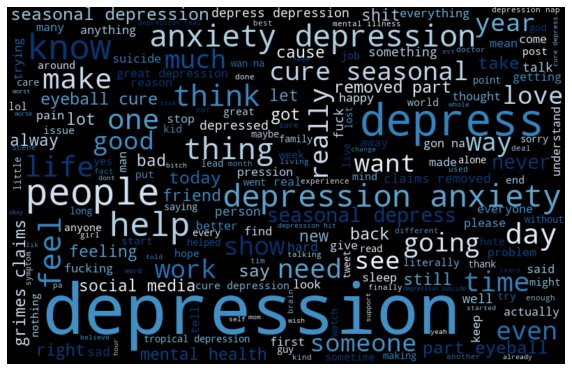

In [21]:
# Depression Tweets
all_words = ' '.join([text for text in X_d])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=512, colormap="Blues").generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('/content/gdrive/MyDrive/data/d_wc.png')
plt.show()

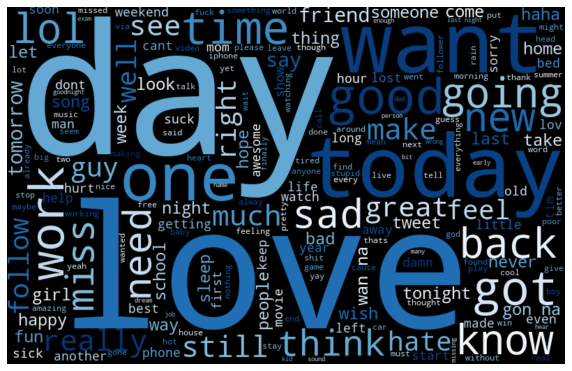

In [22]:
# Random Tweets
all_words = ' '.join([text for text in X_r])
wordcloud = WordCloud(width=800, height=512, colormap="Blues").generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('/content/gdrive/MyDrive/data/r_wc.png')
plt.show()

In [23]:
tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(X_d + X_r)

In [24]:
#Applying the tokenizer to depressive tweets and random tweets data.
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [25]:
#Number of unique words in tokenizer.
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 29619 unique tokens


In [26]:
#Pad sequences to the same length.
data_d = pad_sequences(sequences_d, maxlen=max_tweet_length)
data_r = pad_sequences(sequences_r, maxlen=max_tweet_length)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (14832, 280)
Shape of data_r tensor: (9914, 280)


In [27]:
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [28]:
!pip install word2vec
import word2vec

     |████████████████████████████████| 51kB 5.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-cp37-none-any.whl size=156422 sha256=0fd8243554e4b0f0d2d08b53575521de039da6706f0047b812b0aa6893d5c4f3
  Stored in directory: /root/.cache/pip/wheels/f3/7c/ac/fcb6d867f806021c3730fd848970db988b1d0030b5d20c0e02
Successfully built word2vec


In [29]:
word2vec = KeyedVectors.load_word2vec_format(embedding_file, binary=True)

In [30]:
#The embedding matrix
nb_words = min(max_nb_words, len(word_index))

embedding_matrix = np.zeros((nb_words, embedding_dimen))

for (word, idx) in word_index.items():
    if word in word2vec.wv.vocab and idx < max_nb_words:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [31]:
#TODO: Change this block
#Replace: train_test_split()


# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * d_rows)
labels_r = np.array([0] * r_rows)

# Splitting the arrays into training (60%), validation (20%), and testing data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [32]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), embedding_dimen, weights=[embedding_matrix], 
                            input_length=max_tweet_length, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

nadam = optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [33]:
#TODO: Plot graph


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 300)          7500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 140, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 140, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [34]:
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, 
                 labels_train,
                 validation_data=(data_val, labels_val),
                 epochs=10, 
                 batch_size=128, 
                 shuffle=True,
                 callbacks=[early_stop])

Epoch 1/10
116/116 [==============================] - 221s 2s/step - loss: 0.6137 - acc: 0.6200 - val_loss: 0.3844 - val_acc: 0.8297
Epoch 2/10
116/116 [==============================] - 200s 2s/step - loss: 0.3302 - acc: 0.8673 - val_loss: 0.1858 - val_acc: 0.9265
Epoch 3/10
116/116 [==============================] - 205s 2s/step - loss: 0.1895 - acc: 0.9334 - val_loss: 0.1233 - val_acc: 0.9618
Epoch 4/10
116/116 [==============================] - 204s 2s/step - loss: 0.1287 - acc: 0.9593 - val_loss: 0.1066 - val_acc: 0.9632
Epoch 5/10
116/116 [==============================] - 203s 2s/step - loss: 0.1177 - acc: 0.9631 - val_loss: 0.1010 - val_acc: 0.9638
Epoch 6/10
116/116 [==============================] - 204s 2s/step - loss: 0.1087 - acc: 0.9663 - val_loss: 0.0993 - val_acc: 0.9661
Epoch 7/10
116/116 [==============================] - 201s 2s/step - loss: 0.1002 - acc: 0.9671 - val_loss: 0.0973 - val_acc: 0.9646
Epoch 8/10
116/116 [==============================] - 197s 2s/step - 

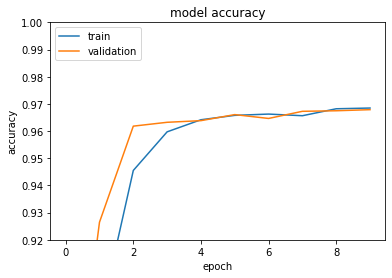

In [36]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.92,1)
plt.savefig('/content/gdrive/MyDrive/data/accuracy plot.png')
plt.show()

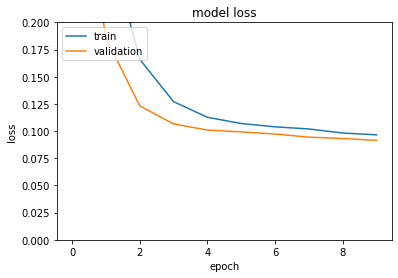

In [37]:
#Summarize for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.2))
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/data/loss plot.png')
plt.show()

In [38]:
Percentage accuracy of model
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.5f%%" % (accuracy*100))

Accuracy: 96.66599%


In [39]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1983
           1       0.99      0.95      0.97      2966

    accuracy                           0.97      4949
   macro avg       0.96      0.97      0.97      4949
weighted avg       0.97      0.97      0.97      4949



In [40]:
model.evaluate(data_test, labels_test)

155/155 [==============================] - 24s 156ms/step - loss: 0.1020 - acc: 0.9667


[0.10200592130422592, 0.9666599035263062]

In [41]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [42]:
score

[0.10200592130422592, 0.9666599035263062]

In [43]:
hist.history

{'acc': [0.6940122842788696,
  0.8900787830352783,
  0.9455108642578125,
  0.9597225189208984,
  0.9641678333282471,
  0.9657843112945557,
  0.966255784034729,
  0.9656496047973633,
  0.9682090878486633,
  0.9684785008430481],
 'loss': [0.5331516265869141,
  0.28313690423965454,
  0.16609515249729156,
  0.12710614502429962,
  0.11271397024393082,
  0.10697584599256516,
  0.10390803217887878,
  0.10193751752376556,
  0.09823090583086014,
  0.0965542271733284],
 'val_acc': [0.8296969532966614,
  0.9264646172523499,
  0.9618181586265564,
  0.9632323384284973,
  0.9638383984565735,
  0.9660605788230896,
  0.9646464586257935,
  0.9672726988792419,
  0.9674747586250305,
  0.9678787589073181],
 'val_loss': [0.3844178318977356,
  0.18579798936843872,
  0.12325140088796616,
  0.10659503936767578,
  0.1009521335363388,
  0.09928703308105469,
  0.09728582203388214,
  0.09444669634103775,
  0.09318262338638306,
  0.09143724292516708]}